In [1]:
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit.primitives import StatevectorSampler as Sampler
from numpy.linalg import eigvalsh


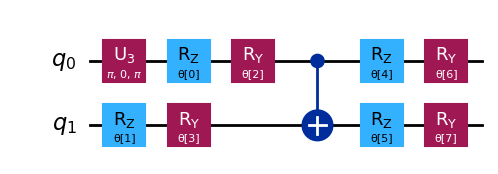

In [2]:

observable_1 = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

    return cost

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
raw_ansatz = reference_circuit.compose(variational_form)

raw_ansatz.decompose().draw('mpl')

In [3]:
estimator = Estimator()
sampler = Sampler()

x0 = np.ones(raw_ansatz.num_parameters)
print(x0)

[1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:
# SciPy minimizer routine
from scipy.optimize import minimize
import time

start_time = time.time()

result = minimize(cost_func_vqe, x0, args=(raw_ansatz, observable_1, estimator), method="COBYLA", options={'maxiter': 1000, 'disp': True})

end_time = time.time()
execution_time = end_time - start_time


   Normal return from subroutine COBYLA

   NFVALS =  130   F =-6.000000E+00    MAXCV = 0.000000E+00
   X = 1.772437E+00   9.581372E-01   1.570751E+00   1.145375E-05   1.916575E+00
       1.225070E+00   6.233763E-01   6.232969E-01


In [5]:
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.999999971198584
       x: [ 1.772e+00  9.581e-01  1.571e+00  1.145e-05  1.917e+00
            1.225e+00  6.234e-01  6.233e-01]
    nfev: 130
   maxcv: 0.0

In [6]:
solution_eigenvalue = min(eigvalsh(observable_1.to_matrix()))

print(f"""Number of iterations: {result.nfev}""")
print(f"""Time (s): {execution_time}""")

print(
    f"Percent error: {abs((result.fun - solution_eigenvalue)/solution_eigenvalue):.2e}"
)

Number of iterations: 130
Time (s): 0.5664403438568115
Percent error: 4.80e-09


Iteration 0: Energy = -0.7760362631880515
Iteration 0: Energy = -0.7760362631880515
Iteration 0: Energy = -0.7760362631880515
Iteration 0: Energy = -0.6329003862241432
Iteration 0: Energy = -1.0112105947953953
Iteration 0: Energy = -1.237665200600898
Iteration 0: Energy = -1.503805154561539
Iteration 0: Energy = -1.2730033823664706
Iteration 0: Energy = -1.4238743950379558
Iteration 0: Energy = -1.7633495050700194
Iteration 0: Energy = -1.3548157652635369
Iteration 0: Energy = -1.7633495050700188
Iteration 0: Energy = -1.7882957511922006
Iteration 0: Energy = -1.726999577895993
Iteration 0: Energy = -1.727973587546881
Iteration 0: Energy = -1.7580210389880064
Iteration 0: Energy = -1.6412686901007147
Iteration 0: Energy = -1.7466267285871746
Iteration 0: Energy = -1.6353385625140306
Iteration 0: Energy = -1.7882957511922006
Iteration 0: Energy = -1.8205348590483146
Iteration 0: Energy = -1.7732649388531099
Iteration 0: Energy = -1.7977048773877458
Iteration 0: Energy = -1.8288027959974

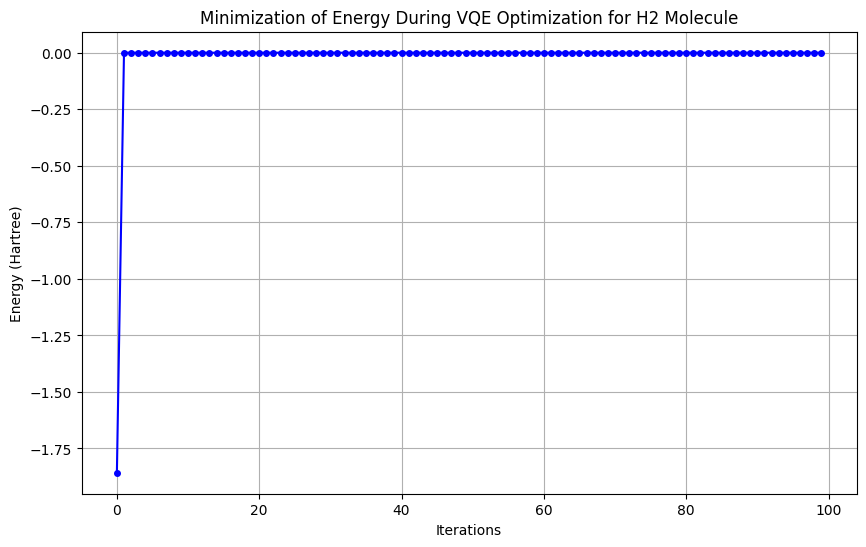

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize
from numpy.linalg import eigvalsh
import time

# Define the Hamiltonian for H2 in the STO-3G basis
# Simplified for demonstration, coefficients will vary based on bond distance
observable_h2 = SparsePauliOp.from_list([("II", -1.052373245772859),
                                         ("IZ", 0.39793742484318045),
                                         ("ZI", -0.39793742484318045),
                                         ("ZZ", -0.01128010425623538),
                                         ("XX", 0.18093119978423156)])


def cost_func_vqe(params, ansatz, hamiltonian, estimator, energy_vals, step):
    """Return estimate of energy from estimator and store the value for heatmap"""
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    energy_vals[step] = cost
    #print(f"Iteration {step}: Energy = {cost}")  # Log energy at each iteration
    return cost


# Define the reference circuit
reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

# Create the variational form (ansatz)
variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
raw_ansatz = reference_circuit.compose(variational_form)

# Initialize the estimator
estimator = Estimator()

# Initial parameters
x0 = np.ones(raw_ansatz.num_parameters)
num_iterations = 100  # Set the number of optimization iterations

# List to store energy values
energy_vals = np.zeros(num_iterations)

# Minimization process using COBYLA
start_time = time.time()
result = minimize(
    cost_func_vqe, 
    x0, 
    args=(raw_ansatz, observable_h2, estimator, energy_vals, 0), 
    method="COBYLA", 
    options={'maxiter': num_iterations, 'disp': True}
)
end_time = time.time()

execution_time = end_time - start_time

# Find the solution eigenvalue
solution_eigenvalue = min(eigvalsh(observable_h2.to_matrix()))

# Print the results
print(f"Number of iterations: {result.nfev}")
print(f"Time (s): {execution_time}")
print(f"Percent error: {abs((result.fun - solution_eigenvalue)/solution_eigenvalue):.2e}")

# # Plot the heatmap of energy values over iterations
# plt.figure(figsize=(10, 6))
# plt.imshow(energy_vals.reshape(-1, 1), cmap='viridis', aspect='auto', interpolation='nearest')
# plt.colorbar(label='Energy Estimate')
# plt.ylim([0,2])
# plt.xlabel('Iterations')
# plt.ylabel('Energy (Hartree)')
# plt.title('Minimization of Energy During VQE Optimization for H2 Molecule')
# plt.show()

# Plot the energy values over iterations
plt.figure(figsize=(10, 6))
plt.plot(energy_vals, color='blue', marker='o', linestyle='-', markersize=4)
plt.xlabel('Iterations')
plt.ylabel('Energy (Hartree)')
plt.title('Minimization of Energy During VQE Optimization for H2 Molecule')
plt.grid()
plt.show()



In [24]:
import numpy as np
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize
from numpy.linalg import eigvalsh
import time

# Define the Hamiltonian for H2 in the STO-3G basis
observable_h2 = SparsePauliOp.from_list([("II", -1.052373245772859),
                                         ("IZ", 0.39793742484318045),
                                         ("ZI", -0.39793742484318045),
                                         ("ZZ", -0.01128010425623538),
                                         ("XX", 0.18093119978423156)])

# Cost function that stores energy values at each step
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator"""
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

# Define the reference circuit
reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

# Create the variational form (ansatz)
variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
raw_ansatz = reference_circuit.compose(variational_form)

# Initialize the estimator
estimator = Estimator()

# Initial parameters
x0 = np.ones(raw_ansatz.num_parameters)
num_iterations = 100  # Set the number of optimization iterations

# Minimization process using COBYLA
start_time = time.time()
result = minimize(
    cost_func_vqe, 
    x0, 
    args=(raw_ansatz, observable_h2, estimator), 
    method="COBYLA", 
    options={'maxiter': num_iterations, 'disp': True}
)
end_time = time.time()

execution_time = end_time - start_time

# Find the solution eigenvalue
solution_eigenvalue = min(eigvalsh(observable_h2.to_matrix()))

# Print the results
print(f"Number of iterations: {result.nfev}")
print(f"Time (s): {execution_time:.4f}")
print(f"Estimated Ground State Energy: {result.fun:.6f} Hartree")
print(f"Classically Calculated Ground State Energy: {solution_eigenvalue:.6f} Hartree")
print(f"Percent Error: {abs((result.fun - solution_eigenvalue)/solution_eigenvalue):.2e}")


Number of iterations: 100
Time (s): 0.3543
Estimated Ground State Energy: -1.857270 Hartree
Classically Calculated Ground State Energy: -1.857275 Hartree
Percent Error: 2.61e-06

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =  100   F =-1.857270E+00    MAXCV = 0.000000E+00
   X = 8.257432E-01  -9.805087E-02   3.974134E-01   2.174475E+00   3.149139E+00
       3.142730E+00   3.329727E-01   1.006770E+00


Number of iterations: 100
Time (s): 0.9288861751556396
Percent error: 1.16e-03

   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =  100   F =-6.787098E+00    MAXCV = 0.000000E+00
   X = 6.370824E-01   1.191303E+00   1.490759E+00   7.152634E-01   3.224850E-02
       2.386824E-01   1.210349E+00   1.599186E+00   1.908127E+00   2.853266E+00
       4.840668E-02  -1.885682E-02  -1.582027E-03   2.876932E+00   1.259283E+00
       1.562644E+00


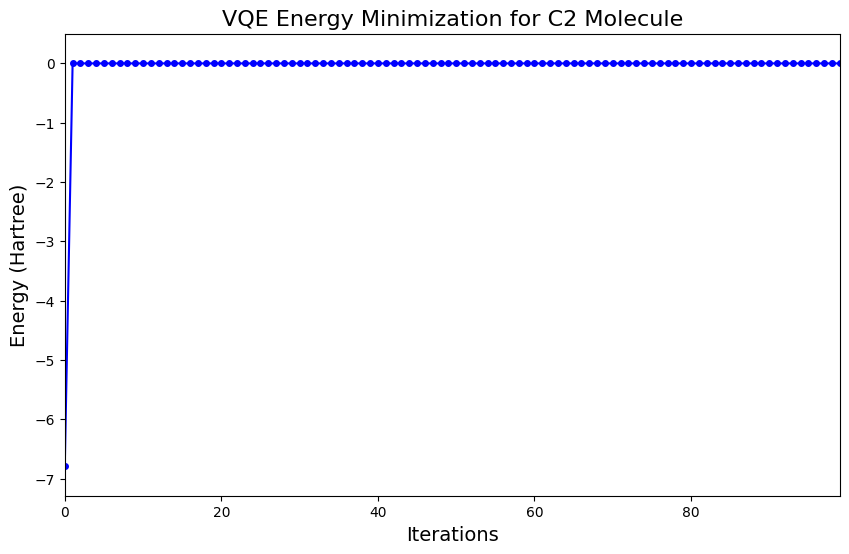

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize
from numpy.linalg import eigvalsh
import time

# Define the Hamiltonian for C2 in the STO-3G basis
observable_c2 = SparsePauliOp.from_list([
    ("IIII", -3.737),
    ("IIIZ", 0.926),
    ("IZII", 0.926),
    ("ZIII", 0.926),
    ("IZZI", -0.033),  # Adjusted to 4 qubits
    ("ZIZI", -0.033),  # Adjusted to 4 qubits
    ("ZZII", -0.033),
    ("IZIZ", 0.226),
    ("IIZZ", 0.226),
    ("ZZZZ", 0.313)
])

def cost_func_vqe(params, ansatz, hamiltonian, estimator, energy_vals, step):
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    energy_vals[step] = cost
    return cost

# Define the reference circuit for 4 qubits
reference_circuit = QuantumCircuit(4)
reference_circuit.x(0)

# Create the variational form (ansatz) for 4 qubits
variational_form = TwoLocal(
    4,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
raw_ansatz = reference_circuit.compose(variational_form)

# Initialize the estimator
estimator = Estimator()

# Initial parameters
x0 = np.ones(raw_ansatz.num_parameters)
num_iterations = 100

# List to store energy values
energy_vals = np.zeros(num_iterations)

# Minimization process using COBYLA
start_time = time.time()
result = minimize(
    cost_func_vqe, 
    x0, 
    args=(raw_ansatz, observable_c2, estimator, energy_vals, 0), 
    method="COBYLA", 
    options={'maxiter': num_iterations, 'disp': True}
)
end_time = time.time()

execution_time = end_time - start_time
solution_eigenvalue = min(eigvalsh(observable_c2.to_matrix()))

# Print the results
print(f"Number of iterations: {result.nfev}")
print(f"Time (s): {execution_time}")
print(f"Percent error: {abs((result.fun - solution_eigenvalue)/solution_eigenvalue):.2e}")

# Set up the figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(0, num_iterations - 1)
ax.set_ylim(np.min(energy_vals) - 0.5, np.max(energy_vals) + 0.5)

# Title and labels
ax.set_title('VQE Energy Minimization for C2 Molecule', fontsize=16)
ax.set_xlabel('Iterations', fontsize=14)
ax.set_ylabel('Energy (Hartree)', fontsize=14)

line, = ax.plot([], [], color='blue', marker='o', linestyle='-', markersize=4)

# Initialize the plot
def init():
    line.set_data([], [])
    return line,

# Update the plot for each frame
def update(frame):
    line.set_data(np.arange(frame + 1), energy_vals[:frame + 1])
    return line,

# Create the animation
ani = FuncAnimation(fig, update, frames=num_iterations, init_func=init, blit=True)

# Save the animation as a GIF
ani.save('vqe_energy_minimization_c2.gif', writer='pillow', fps=10)

plt.show()


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize
from numpy.linalg import eigvalsh
import time
import imageio
import os

# Observable coefficients for 4 qubits (C₂ molecule)
observable_c2 = SparsePauliOp.from_list([
    ("IIII", -373.7),
    ("IIIZ", 92.6),
    ("IZII", 92.6),
    ("ZIII", 92.6),
    ("IZZI", -3.3),
    ("ZIZI", -3.3),
    ("ZZII", -3.3),
    ("IZIZ", 22.6),
    ("IIZZ", 22.6),
    ("ZZZZ", 31.3)
])

def cost_func_vqe(params, ansatz, hamiltonian, estimator, energy_vals, step):
    """Return estimate of energy from estimator and store the value."""
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    energy_vals[step] = cost
    return cost

# Define the reference circuit
reference_circuit = QuantumCircuit(4)
reference_circuit.x(0)  # Initial state for the first qubit

# Create the variational form (ansatz)
variational_form = TwoLocal(
    4,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
raw_ansatz = reference_circuit.compose(variational_form)

# Initialize the estimator
estimator = Estimator()

# Initial parameters
x0 = np.ones(raw_ansatz.num_parameters)
num_iterations = 100

# List to store energy values
energy_vals = np.zeros(num_iterations)

# Minimization process using COBYLA
start_time = time.time()
result = minimize(
    cost_func_vqe, 
    x0, 
    args=(raw_ansatz, observable_c2, estimator, energy_vals, 0), 
    method="COBYLA", 
    options={'maxiter': num_iterations, 'disp': True}
)
end_time = time.time()

execution_time = end_time - start_time
solution_eigenvalue = min(eigvalsh(observable_c2.to_matrix()))

# Print the results
print(f"Number of iterations: {result.nfev}")
print(f"Time (s): {execution_time}")
print(f"Percent error: {abs((result.fun - solution_eigenvalue)/solution_eigenvalue):.2e}")

# Create GIF of energy minimization
filenames = []

for i in range(num_iterations):
    plt.figure()
    plt.plot(np.arange(i + 1), energy_vals[:i + 1], marker='o', color='blue')
    plt.title('Minimization of Energy During VQE Optimization for C₂ Molecule')
    plt.xlabel('Iterations')
    plt.ylabel('Energy (scaled)')
    plt.ylim(min(energy_vals) - 10, max(energy_vals) + 10)  # Adjust Y limits for clarity
    plt.grid()
    
    # Save each frame as a PNG file
    img_file = f"frame_{i}.png"
    plt.savefig(img_file)
    plt.close()  # Close the figure to avoid display
    filenames.append(img_file)

# Create GIF from images
with imageio.get_writer('vqe_energy_minimization.gif', mode='I', duration=0.1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Clean up the frame images if desired
for filename in filenames:
    os.remove(filename)


Number of iterations: 100
   Return from subroutine COBYLA because the MAXFUN limit has been reached.


Time (s): 1.6489121913909912
Percent error: 1.16e-03
   NFVALS =  100   F =-6.787098E+02    MAXCV = 0.000000E+00
   X = 6.370824E-01   1.490759E+00   1.191303E+00   7.152634E-01   3.224850E-02
       2.386824E-01   1.210349E+00   1.599186E+00   1.908127E+00   2.853266E+00
       4.840668E-02  -1.885682E-02  -1.582027E-03   2.876932E+00   1.259283E+00
       1.562644E+00


/tmp/ipykernel_87201/662195678.py:98: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.

